In [157]:
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision      # 数据库模块

import numpy as np
import matplotlib.pyplot as plt

#torch.manual_seed(1)    # reproducible

In [158]:
#Hyper Parameters
EPOCH = 1           # 训练整批数据多少次, 为了节约时间, 我们只训练一次
BATCH_SIZE = 50
LR = 0.001          # 学习率

torch.Size([60000, 28, 28])
torch.Size([60000])


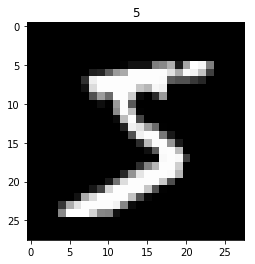

In [159]:
# Mnist 手写数字
train_data = torchvision.datasets.MNIST(             #这种加载形式有train_data.train_data和train_data.train_labels两个子函数
    root='./data1/MNIST/',    # 保存或者提取位置
    train=True,  # this is training data
    download=True,
    transform=torchvision.transforms.ToTensor(),
)

print(train_data.train_data.size())              #60000*28*28
print(train_data.train_labels.shape)             #60000

plt.imshow(train_data.train_data[0],cmap="gray")
plt.title("%d" % train_data.train_labels[0])
plt.show()

In [160]:
train_loader = torch.utils.data.DataLoader(  
    train_data                                               
    ,batch_size=BATCH_SIZE                                       
    ,shuffle=True                                            
)

In [161]:
#注意，最关键的是注意搭建了几层layer，每层layer的参数是多少，为什么这么设置
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(  # input shape (1, 28, 28)        
            nn.Conv2d(
                in_channels=1,      # input height
                out_channels=16,    # n_filters
                kernel_size=5,      # filter size
                stride=1,           # filter movement/step
                padding=2,      # 如果想要 con2d 出来的图片长宽没有变化, padding=(kernel_size-1)/2 当 stride=1 !!
            ),      # output shape (16, 28, 28)
            nn.ReLU(),    # activation
            nn.MaxPool2d(kernel_size=2),    # 在 2x2 空间里向下采样, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(  # input shape (16, 14, 14)
            nn.Conv2d(16, 32, 5, 1, 2),  # output shape (32, 14, 14)
            nn.ReLU(),  # activation
            nn.MaxPool2d(2),  # output shape (32, 7, 7)
        )
        self.out = nn.Linear(32 * 7 * 7, 10)   # fully connected layer, output 10 classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)   # 展平多维的卷积图成 (batch_size, 32 * 7 * 7)
        output = self.out(x)
        return output
    
cnn = CNN()
print(cnn)  # net architecture

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [162]:
def pred_rate(preds,labels):
    return preds.eq(labels).sum().item()/labels.shape[0]

In [163]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")    #如果可以，network使用GPU
network=CNN().to(device)

optimizer = torch.optim.Adam(network.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()   # the target label is not one-hotted

for epoch in range(EPOCH):
    for step,(batch_x,batch_y) in enumerate(train_loader):
        batch_x,batch_y=batch_x.to(device),batch_y.to(device)     #如果可以，tensor放到gpu上
        
        out=network(batch_x)
        loss=loss_func(out,batch_y)            
        
        optimizer.zero_grad()
        loss.backward()                         #使用backpropogation算法计算grad
        optimizer.step()    #表示将要用该optimizer，通过loss function的最小化来更新weights
        
        if step%50 == 0:
            preds=out.argmax(dim=1)
            print('Epoch: ', epoch, '| Step: ', step,'| loss: ',loss.item(), '| prection rate: ',pred_rate(preds,batch_y))
        


Epoch:  0 | Step:  0 | loss:  2.2986645698547363 | prection rate:  0.22
Epoch:  0 | Step:  50 | loss:  0.48384106159210205 | prection rate:  0.82
Epoch:  0 | Step:  100 | loss:  0.3647906482219696 | prection rate:  0.88
Epoch:  0 | Step:  150 | loss:  0.4928910732269287 | prection rate:  0.82
Epoch:  0 | Step:  200 | loss:  0.2735483646392822 | prection rate:  0.88
Epoch:  0 | Step:  250 | loss:  0.09300849586725235 | prection rate:  0.98
Epoch:  0 | Step:  300 | loss:  0.38477760553359985 | prection rate:  0.88
Epoch:  0 | Step:  350 | loss:  0.06717167049646378 | prection rate:  0.98
Epoch:  0 | Step:  400 | loss:  0.25165218114852905 | prection rate:  0.96
Epoch:  0 | Step:  450 | loss:  0.04228585213422775 | prection rate:  1.0
Epoch:  0 | Step:  500 | loss:  0.017579160630702972 | prection rate:  1.0
Epoch:  0 | Step:  550 | loss:  0.03588689863681793 | prection rate:  1.0
Epoch:  0 | Step:  600 | loss:  0.04718918353319168 | prection rate:  0.98
Epoch:  0 | Step:  650 | loss:  0.

In [165]:
test_data = torchvision.datasets.MNIST(               #这种加载形式有test_data.test_data和test_data.test_labels两个子函数
    root='./data1/MNIST/',    # 保存或者提取位置
    train=False,  # this is testing data
    download=True,
    transform=torchvision.transforms.ToTensor(),    
)
 
test_loader = torch.utils.data.DataLoader(test_data)

sum_correct=0
for test_x,test_y in test_loader:               #test_loader里面要一个一个数据取，用for
    test_x,test_y=test_x.to(device),test_y.to(device)           #转移到GPU
    out=network(test_x)
    pred=out.argmax(dim=1)
    sum_correct+=(pred.cpu().data.numpy().item()==test_y.cpu().data.numpy().item()) #GPU tensor先变成CPU tensor，
                                                                                    #再变成numpy数组，再变成数字
my_rate=sum_correct/len(test_data)
print('By using the test set,the prediction rate is: ',my_rate)

By using the test set,the prediction rate is:  0.9829
